In [35]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from qutip import *

font = {'size'   : 45}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 12, 10
matplotlib.rcParams['lines.linewidth'] = 4
props = dict(boxstyle='round', ec='black', fc='white', alpha=0.8)

deltaD = 0.001
rho = 2/deltaD
nj = rho*deltaD

## Denominators

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{D}{2} - \frac{U}{2} + \frac{K}{4}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}, \quad d_3 = \omega - \frac{D}{2} + \frac{K}{4}
$$

In [2]:
def den(w, D, U, J, K):
    d0 = w - D/2 - U/2 + K/4
    d1 = w - D/2 + U/2 + J/4
    d2 = w - D/2  + J/4
    d3 = w - D/2  + K/4
    return np.array([d0, d1, d2, d3])

## RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 
$$
\Delta U = 4V^2 n_j\left(\frac{1}{d_0} - \frac{1}{d_1}\right) - \frac{n_j}{2}\left(\frac{J^2}{d_2} - \frac{K^2}{d_3}\right),\\
\Delta V = -\frac{3n_j V}{8}\left[J\left(\frac{1}{d_2} + \frac{1}{d_1}\right) + K \left(\frac{1}{d_3} + \frac{1}{d_0}\right)\right],\\
\Delta J = -\frac{n_j J^2}{d_2}, \quad\quad\Delta K = -\frac{n_j K^2}{d_3}
$$

In [3]:
def rg1(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2) if d1 < 0 else 0
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8 if d1 < 0 else 0
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

def rg2(w, D, U, V, K):
    J = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) + nj*K**2/(2*d3) if d0 < 0 else 0
    deltaV = -3*nj*V*K*(1/d0 + 1/d3)/8 if d0 < 0 else 0
    deltaK = -nj*K**2/d3

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    K = 0 if (K + deltaK) * K <= 0 else K + deltaK

    return U, V, K

def rg3(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2)
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [4]:
def complete_RG(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg1(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

def complete_RG2(w, D0, U0, V0, K0):
    U = [U0]
    V = [V0]
    K = [K0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, K_j = rg2(w, D, U[-1], V[-1], K[-1])
        U.append(U_j)
        V.append(V_j)
        K.append(K_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], 0, K[-1])
        if d3 >= 0:
            break
    return np.array(E), np.array(U), np.array(V), np.array(K)

def complete_RG3(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg3(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

## Positive $U$ regime

In [ ]:
D0 = 10
w = -D0/2
U0 = D0/10
V0 = D0/100
J0 = D0/200
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
fig, ax = plt.subplots(1, 3, figsize=(30,8))
ax[0].plot(steps, U/D0)
ax[0].set_xlabel(r"\% of RG completed")
ax[0].set_ylabel(r"$U/D_0$")
ax[1].plot(steps, V/D0)
ax[1].set_xlabel(r"\% of RG completed")
ax[1].set_ylabel(r"$V/D_0$")
ax[1].set_yscale("log")
ax[2].plot(steps, J/D0)
ax[2].set_xlabel(r"\% of RG completed")
ax[2].set_ylabel(r"$J/D_0$")
ax[2].set_yscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
ax[1].text(0.5, 0.8, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
plt.tight_layout()
# plt.savefig("U_irr,U>0.pdf", bbox_inches='tight')
U0 = D0/10
V0 = D0/200
J0 = D0/100
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
fig, ax = plt.subplots(1, 3, figsize=(30,8))
ax[0].plot(steps, U/D0)
ax[0].set_xlabel(r"\% of RG completed")
ax[0].set_ylabel(r"$U/D_0$")
ax[0].set_yscale("log")
ax[1].plot(steps, V/D0)
ax[1].set_xlabel(r"\% of RG completed")
ax[1].set_ylabel(r"$V/D_0$")
ax[1].set_yscale("log")
ax[2].plot(steps, J/D0)
ax[2].set_xlabel(r"\% of RG completed")
ax[2].set_ylabel(r"$J/D_0$")
ax[2].set_yscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
ax[1].text(0.5, 0.8, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
plt.tight_layout()
# plt.savefig("U_rel,U>0.pdf", bbox_inches='tight')

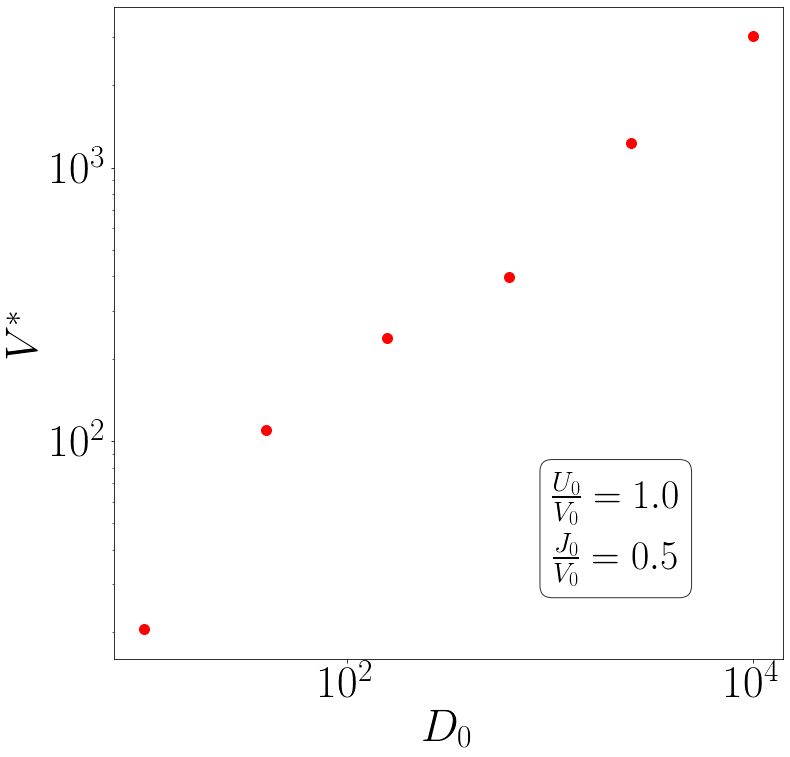

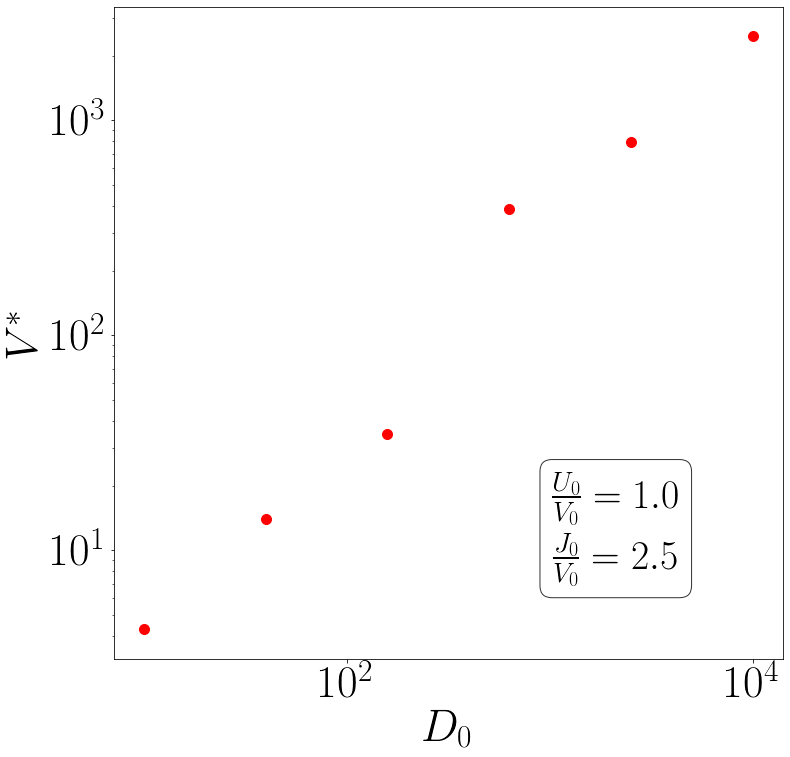

In [176]:
Drange = 10**np.linspace(1, 4, 6)
U0 = 0.1
V0 = 0.1
J0 = 0.05
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

V0 = 0.1
J0 = 0.25
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_smallV.pdf", bbox_inches='tight')

## Get phase map of relevance of $U$ in the $J-V$ plane

In [ ]:
def get_rel_V(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-3, 1, 100):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(V0/D0)
        else:
            if V0 == 1e-3:
                print ("Outlier:", J0/D0)
            irr.append(V0/D0)
    return rel, irr

D0 = 100
w = -D0/2
U0 = 0.5
J0_range = 10**np.linspace(-3, 1, 100)
results = list(tqdm(Pool().imap(get_rel_V, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_0/D_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get phase map of $J^*/V^*$ in $J$ vs $V$

In [ ]:
def get_rel_JbyV(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-2.5, 0, 50)*J0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1] > V[-1]:
            rel.append(V0/D0)
        else:
            irr.append(V0/D0)
    return rel, irr

D0 = 10000
w = -D0/2
U0 = D0/10
J0_range = 10**np.linspace(-2.5, -1, 50)*D0
results = list(tqdm(Pool().imap(get_rel_JbyV, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$J^* > V^*$")
plt.plot([],[],color='b', label=r"$J^* < V^*$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_0/D_0$")
# plt.plot(J0_range/D0 + 0.5*10**(-3), J0_range/D0, ls='--')
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get phase map of relevance of $U$ in the $J-U$ plane

In [ ]:
def get_rel_U(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-4, 3, 300):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(U0/D0)
        else:
            if U0 == 1e-4:
                print ("Outlier:", J0/D0)
            irr.append(U0/D0)
    return rel, irr

D0 = 100
w = -D0/2
V0 = 0.1
J0_range = 10**np.linspace(-3, 1, 100)
results = list(tqdm(Pool(40).imap(get_rel_U, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_0/D_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Get critical $U$ at partition for given $J$ over range of $J$

In [ ]:
def get_Uc(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-6, 3, 200):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return U0/D0

D0 = 100
w = -D0
V0 = 0.2
J0_range = 10**np.linspace(-3.5, 1, 100)
Uc = list(tqdm(Pool(40).imap(get_Uc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Uc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_c/D_0$")
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UcvsJ.pdf", bbox_inches='tight')
plt.show()

## Get critical $V$ at partition for given $J$ over range of $J$

In [ ]:
def get_Vc(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-3, 1, 100):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return V0/D0

D0 = 100
w = -D0
U0 = 1
J0_range = 10**np.linspace(-3, 1, 200)
Vc = list(tqdm(Pool(40).imap(get_Vc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Vc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_c/D_0$")
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VcvsJ.pdf", bbox_inches='tight')
plt.show()

In [ ]:
def get_Jc(D0):
    U0 = D0
    V0 = D0/100
    J0 = V0/10000
    w = -D0
    acc = -5
    deltaj = 1
    while np.log10(abs(deltaj)) > acc:
#         print (np.log10(abs(deltaj)))
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1]/V[-1] > 1:
            deltaj /= -10
#             print (deltaj)
        J0 += deltaj
    
    print ((J0 - deltaj)/D0)
    return (J0 - deltaj)/D0

U0 = 1
V0 = 0.1
Drange = 10**np.linspace(1, 5, 5)
Jc = np.array(list(tqdm(Pool(1).imap(get_Jc, Drange), total=len(Drange))))
plt.scatter(Drange, Jc)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$D_0$")
plt.ylabel(r"$J_c/D_0$")
plt.text(0.8, 0.8, r"$U_0/V_0 = {:.2f}$".format(U0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("Jc_vs_D0.pdf", bbox_inches='tight')

## Get $c_s, c_c$ that characterise ground state, for multiple $J$

In [ ]:
def get_cs(J0):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    N = E[-1]/deltaD
    v = V[-1]
    j = J[-1]
    u = U[-1]
    gamma = (3*j/8 + u/4)/v
    # print (gamma)
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    return (c1sq, c2sq)

In [ ]:
D0 = 100
w = -D0/2
V0 = D0/100
J0_range = 10**np.linspace(-2.5, 0, 100)*D0
fig, ax = plt.subplots(1,2, figsize=(25, 10))
i = 0
for U0 in [D0/1000, D0/10]:
    results = list(tqdm(Pool().imap(get_cs, J0_range), total=len(J0_range)))
    c1sq_arr = [c1 for c1,c2 in results]
    c2sq_arr = [c2 for c1,c2 in results]

    ax[i].scatter(J0_range/D0, c1sq_arr, color='r', label=r"$c_s^2$")
    ax[i].scatter(J0_range/D0, c2sq_arr, color='b', label=r"$c_c^2$")

    ax[i].set_xscale("log")

    ax[i].set_xlabel(r"$J_0/D_0$")
    ax[i].set_ylabel(r"$c_s^2$, $c_c^2$")

    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0)])
    ax[i].text(0.45, 0.5, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
    ax[i].axhline(1,0,1, ls="--", color='black', label=r"$c^2=1$")
    ax[i].axhline(0,0,1, ls="--", color='green', label=r"$c^2=0$")
    ax[i].legend()
    i += 1

plt.tight_layout()
# plt.savefig("coeffs_vs_J.pdf", bbox_inches='tight')

## $c_s$ $c_c$ under increase of $D_0$

100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


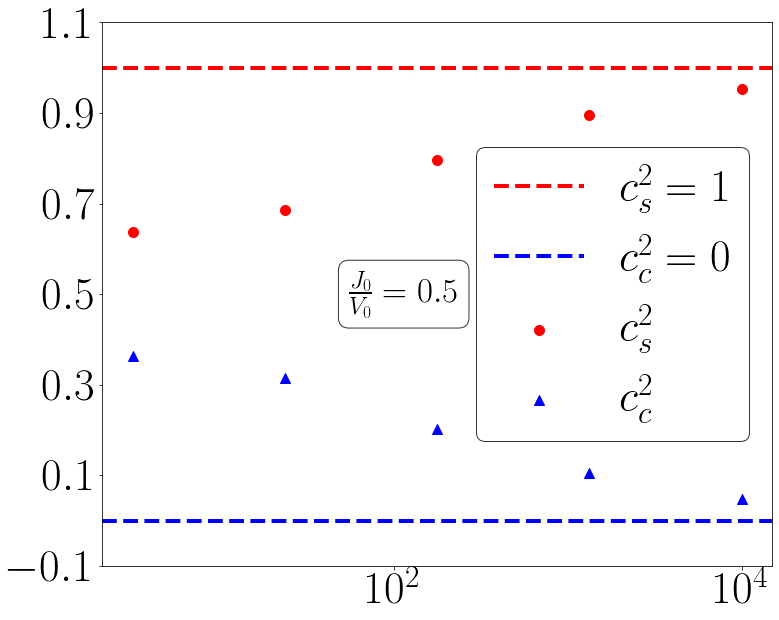

100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


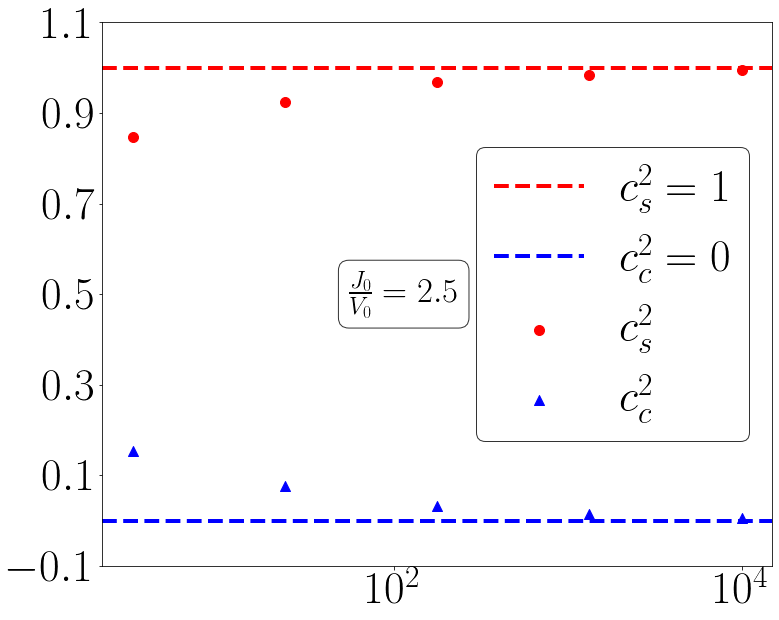

In [184]:
Drange = 10**np.linspace(0.5, 4, 5)
U0 = 0.1
V0 = 0.1
J0 = 0.05
for D0 in tqdm(Drange):
    w = -D0/2
    c1sq, c2sq = get_cs(J0)
    plt.scatter(D0, c1sq, s=100, color='r')
    plt.scatter(D0, c2sq, s=100, color='b', marker='^')

plt.scatter([], [], s=100, color='r', label=r'$c_s^2$')
plt.scatter([], [], s=100, color='b', label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
plt.savefig("coeffs_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

U0 = 0.1
V0 = 0.1
J0 = 0.25
for D0 in tqdm(Drange):
    w = -D0/2
    c1sq, c2sq = get_cs(J0)
    plt.scatter(D0, c1sq, s=100, color='r')
    plt.scatter(D0, c2sq, s=100, color='b', marker='^')

plt.scatter([], [], color='r', s=100, label=r'$c_s^2$')
plt.scatter([], [], color='b', s=100, label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
plt.savefig("coeffs_vs_D_smallV.pdf", bbox_inches='tight')

## $\gamma$ as a function of $D_0$

## Compare states to find ground state

In [ ]:
def get_Es(J0):
    if U0 > 0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        K = [0]
    else:
        E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
        # print (U0, K[-1])
        J = [0]
    v = V[-1]
    j = J[-1]
    u = U[-1]
    k = K[-1]
    gamma = (3*j/8 + k/8 + u/4)/v
    delta = np.sqrt(u**2 + 16*v**2)/2
    E1 = -u/4 - delta/2
    E2 = v*(gamma - np.sqrt(gamma**2 + 4)) - u/2 - 3*j/4
    E3 = -3*k/4
    return (E1, E2, E3)
    
    
D0 = 300
w = -D0/2
J0 = 0
U0 = -D0/10
V0 = D0/50
K_rang = 10**np.linspace(-2.4, -1, 100)*D0
cols = ['r', 'b', 'g']
for K0 in tqdm(K_rang, total=len(K_rang)):
    E1, E2, E3 = get_Es(J0)
    col = 'r' if E1 < E3 else 'b'
    plt.scatter(K0/D0, 0, color=col)

plt.axvline(V0/D0, 0, 1, ls='--', color='black', label=r"$V_0/D_0$")
plt.scatter([], [], color='r', label=r"$E_1 < E_3$")
plt.scatter([], [], color='b', label=r"$E_1 > E_3$")
plt.legend()
plt.xscale("log")

## Diagonalise $H$ in order to calculate $\chi$

In [ ]:
def get_ham(U,V,J,K,h1,h2):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    H_U = (-U/2) * tensor(Sz**2, identity(2), identity(2))
    H_V = V * tensor(crt, identity(2), des, identity(2)) + V * tensor(identity(2), crt, identity(2), des)
    H_V += H_V.dag()
    H_J = J * (tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp))
    H_K = K * (tensor(Cz, Cz) + 0.5*tensor(Cp, Cm) + 0.5*tensor(Cm, Cp))
    H_h1 = h1 * tensor(Sz, identity(2), identity(2))
    H_h2 = h2 * tensor(Cz, identity(2), identity(2))
    return H_U + H_V + H_J + H_K + H_h1 + H_h2

## Calculate $\chi_s, \chi_c$

In [ ]:
def get_Ens(args):
    U,V,J,K,h1,h2 = args
    H = get_ham(U,V,J,K,h1,h2)
    E,_ = H.eigenstates()
    return E

def get_Z(E, deltah, Trange):
    E0, E1, E2 = E
    Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
    ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
    Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
    Zp = (ZplusdeltaZ - Z) / deltah
    Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
    return Z, Zp, Zpp
    

def get_chi_spin(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,deltah,0))/norm
    E2 = get_Ens((U,V,J,K,2*deltah,0))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

def get_chi_charge(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,0,deltah))/norm
    E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

D0 = 100
w = -D0/2

## $U>0$ regime, $\chi_s$

In [ ]:
U0 = D0/10
V0 = D0/10
J0 = V0*2
K = 0

E, U, V, J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
print (U,V,J)

Trange = 10**np.linspace(1, 4, 100)
chi = get_chi_spin(U,V,J,K,Trange)
Trange = Trange[~np.isnan(chi)]
chi = chi[~np.isnan(chi)]
print (chi[0])
plt.scatter(Trange/D0, chi*Trange, color='r')
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi \times T$")
plt.axhline(1/8, 0, 1, ls="--", color='black')
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chiT_J={:.3f}.pdf".format(J0/D0), bbox_inches='tight')
plt.show()

## $U>0$ regime, $\chi_c$

In [ ]:
U0 = D0/10
V0 = D0/10
K = 0
names = ('small', 'large')
for name, J0 in zip(names, (V0/2, V0*2)):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]
    print (U,V,J)
    Trange = 10**np.linspace(0, 5, 100)
    chi = get_chi_charge(U,V,J,K,Trange)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    print (chi[0])
    plt.scatter(Trange/D0, chi, color='r')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi_c$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chiC_posU_J={}.pdf".format(name), bbox_inches='tight')
    plt.show()

## Calculate $\chi$ in $U<0$

In [ ]:
D0 = 80
w = -D0/2
J = 0
U0 = -D0/10
V0 = D0/100
K0 = D0/10
E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
U = U[-1]
V = V[-1]
K = K[-1]
print (U,V,K)

deltah = 1e-1
norm = 1
E0 = get_Ens((U,V,J,K,0,0))/norm
print (min(E0))
E1 = get_Ens((U,V,J,K,0,deltah))/norm
E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
Trange = 10**np.linspace(-1, 5, 100)

Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
Zp = (ZplusdeltaZ - Z) / deltah
# print (E0)
Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
chi = Trange * (Zpp/Z - (Zp/Z)**2)

plt.scatter(Trange/D0, chi*Trange, color='r')
plt.axhline(1/8, 0, 1, ls="--", color='b', label=r"$\frac{1}{8}$")
# plt.yscale("log")
plt.legend()
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi_c \times T$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$K_0/D_0 = {}$".format(K0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chi_chargeT_K={:.3f}.pdf".format(K0/D0), bbox_inches='tight')

## Specific Heat $C_V$

In [5]:
def get_full_ham(t, dim, U, V, J):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    
    H_U = (-U/2) * tensor([Sz**2] + [identity(2)]*2*dim)
    
    H_V = V * tensor([tensor(crt, identity(2), des, identity(2)) + tensor(identity(2), crt, identity(2), des)] + [identity(2)]*2*(dim - 1))
    H_V += H_V.dag()
    
    H_J = J * tensor([tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp)] + [identity(2)]*2*(dim - 1))
    
    H_K = 0
    for i in range(0, dim):
        if i < dim - 1:
            H_K += -t * tensor([identity(2)]*2*(1+i) + [crt, identity(2)] + [des, identity(2)] + [identity(2)]*2*(dim - i - 2))
            H_K += -t * tensor([identity(2)]*2*(1+i) + [identity(2), crt] + [identity(2), des] + [identity(2)]*2*(dim - i - 2))
        else:
            H_K += -t * tensor([identity(2)]*2*(1) + [des, identity(2)] + [identity(2)]*2*(dim - 2) + [crt, identity(2)])
            H_K += -t * tensor([identity(2)]*2*(1) + [identity(2), des] + [identity(2)]*2*(dim - 2) + [identity(2), crt])
    H_K = H_K + H_K.dag()
    
    H = H_K + H_U + H_V + H_J
    return H

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-78-b714bac89f5c>:3: RuntimeWarning: overflow encountered in exp
  E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
<ipython-input-78-b714bac89f5c>:3: RuntimeWarning: invalid value encountered in double_scalars
  E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
<ipython-input-78-b714bac89f5c>:5: RuntimeWarning: overflow encountered in exp
  E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
<ipython-input-78-b714bac89f5c>:5: RuntimeWarning: invalid value encountered in double_scalars
  E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
<ipython-input-78-b714bac89f5c>:5: RuntimeWarning: overflow encountered in multiply
  E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
<ipython-input-78-b714bac89f5c>:3: RuntimeWarning: overflow encountered in multiply
  E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
100%|██████████| 500/500 [00:00<00:00

ED Done


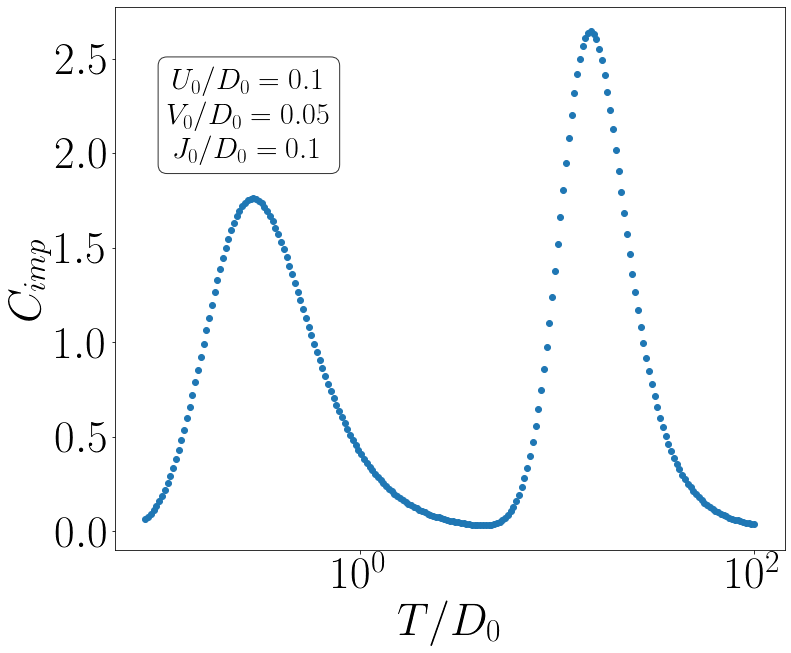

In [78]:
def get_Cv(T):
    deltaT = T/100
    E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    T += deltaT
    E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    C_V_T = (E_avg_T_plus_deltaT - E_avg_T)/deltaT
    return C_V_T

D0 = 1000
w = -D0/2
U0 = D0/10
J0 = D0/10
V0 = D0/20
dim = 4
E,U,V,J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
t = J/150
# print (U,V,J)
H = get_full_ham(t, dim, U, V, J)
Ens, X = H.eigenstates()
print ("ED Done")
Trange = 10**np.linspace(-2, 5, 500)
Cv = []
for T in tqdm(Trange):
    Cv.append(get_Cv(T))
plt.scatter(Trange/D0, Cv)
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$C_{{imp}}$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.8, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Cv.pdf", bbox_inches='tight')
plt.show()

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

In [ ]:
D0 = 20
V0 = 0

In [ ]:
def plot(x,y,ylabels,locn,bare,log=[]):
    if log == []:
        log = [0]*len(y)
    for yi,yl,logi in zip(y, ylabels, log):
        plt.plot(x,yi)
        plt.ylabel(yl)
        plt.xlabel(r'RG Step')
        text = '\n'.join([r"$J_0={}, K_0={}, V_0 = {}$,".format(*bare[:3]), r"$U_0={}, D_0={}, \omega={}\times D$".format(*bare[3:])])
        plt.text(locn[0], locn[1], text, bbox=props, size=25, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.tight_layout()
        if logi == 1:
            plt.yscale("log")
        plt.show()


## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

In [ ]:
U0 = 1
J0 = K0 = 0.1
E,U,V,J,K = complete_RG(lambda x: x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J), (r"$U$", r"$J$"), (0.4,0.8), (J0, K0, 0, U0, D0, 1))

### ii. $J > K$

$U$ will be irrelevant here.

In [ ]:
U0 = 6
J0 = 0.02
K0 = 0.01
E,U,V,J,K = complete_RG(lambda x: x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.4,0.8), (J0, K0, 0, U0, D0, 1))

### iii. $J < K$

$U$ will be relevant here.

In [ ]:
U0 = 0.1
J0 = 0.02
K0 = 0.03

E,U,V,J,K = complete_RG(lambda x:x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J), (r"$U$", r"$J$"), (0.3,0.5), (J0, K0, 0, U0, D0, 1), log=[1,1])

## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

In [ ]:
U0 = 0.01
J0 = 0.05
K0 = 0.04

E,U,V,J,K = complete_RG(lambda x:-x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.6,0.8), (J0, K0, 0, U0, D0, -0.5), log=[1,1,1])

### i. $J<K$

In [ ]:
U0 = 20
J0 = 0.01
K0 = 0.1

E,U,V,J,K = complete_RG(lambda x: -x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.7,0.5), (J0, K0, 0, U0, D0, -1), log=[0,1,1])

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

In [ ]:
w = lambda x:0
U0 = 1
J0 = 0.01
K0 = 0.02
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.xlabel(r"$K$")
plt.ylabel(r"$J$")
plt.plot(K, J, label=r'$J<K$')
J0 = 0.02
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J>K$')
J0 = 0.01
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J=K$')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title(r"$\omega = {}, U_0 = {}, D_0={}$".format(0, U0, D0))
plt.show()

# 2. $V > 0$

$$
	\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{\epsilon_q}{2} - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$
$$
	\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{\epsilon_q}{2} - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K} \right)
$$
$$
	\Delta J = - \frac{J^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$
$$
	\Delta K = - \frac{K^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$

## $U>0, 0 < J = -K$

In [ ]:
D0 = 50
V0 = D0/10
J0 = V0
K0 = -J0/1.2

### $\omega < \frac{D_0}{2} - U$

In [ ]:
w0 = -D0/2 - abs(J0)/4 - abs(K0)/4 - abs(U0)/2

In [ ]:
def get_bounds(U0):
    w0 = -D0/2 - abs(J0)/4 - abs(K0)/4 - abs(U0)/2
    lower = []
    upper = []
    for wi in w0*10**np.linspace(3, -3, 50):
        w = lambda x: wi
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        if U[-1] >= U0:
            lower.append((wi, 1))
        else:
            # print (0)
            lower.append((wi, 0))
    return lower
    # for wi in np.linspace(w0, w0*1e5, 10000):
    #     w = lambda x: wi
    #     E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    #     if U[-1] >= U0:
    #         upper = w(0)
    #         break
    # return (lower, upper)

U0_range = D0*10**np.linspace(-3, 3, 30)
up = []
lw = []
# for bound in list(tqdm(Pool().imap(get_bounds, U0_range), total=len(U0_range))):
#     up.append(bound[1])
#     lw.append(bound[0])

plt.figure(figsize=(30,20))

spectrum = list(tqdm(Pool().imap(get_bounds, U0_range), total=len(U0_range)))
for U0, state in zip(U0_range, spectrum):
    rel = []
    irr = []
    for wi, sign in state:
        # print (wi)
        if sign == 0:
            irr.append(wi)
            # print (irr[-1])
        else:
            rel.append(wi)
    plt.scatter([U0/D0]*len(irr), -np.array(irr), color='b')
    plt.scatter([U0/D0]*len(rel), -np.array(rel), color='r')  
        
# up = np.array(up)
# lw = np.array(lw)

# plt.plot(U0_range/D0, -up/D0, color='r', label=r'$-\omega_{c,+}/D_0$')
# plt.plot(U0_range/D0, -lw/D0, color='b', label=r'$-\omega_{c,-}/D_0$')
# plt.xlabel(r"$U_0/D_0$")
# plt.ylabel(r"$-\omega_c/D_0$")
plt.xscale("log")
plt.yscale("log")
# plt.legend()
# plt.text(0.22, 0.5,'\n'.join([r"$V_0/D_0={:.2f}$".format(V0/D0), r"$J_0/D_0={:.2f}$".format(J0/D0), r"$K_0/D_0={:.3f}$".format(K0/D0)]), bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

In [ ]:
D0 = 10
V0 = D0/40
J0 = V0
K0 = -J0/2
U0 = 10
w0 = -D0/2 - abs(J0)/4 - abs(K0)/4 - abs(U0)/2
lw, up = get_bounds(U0)
print (lw, up, (lw + up)/2)
for wi in (lw/3, -50, up):
    fig, ax = plt.subplots(1,3, figsize=(30,6))
    w = lambda x: wi
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    steps = np.array(E)/D0
    ax[0].plot(steps, U)
    ax[0].set_ylabel(r"$U$")
    ax[1].plot(steps, V)
    ax[1].set_ylabel(r"$V$")
    ax[2].plot(steps, J)
    ax[2].set_ylabel(r"$J$")
    plt.show()

In [ ]:
D0 = 20
V0 = 0.1
J0 = 0.01
K0 = -J0
w = lambda x: -x/2

for U0 in [1, 0.5, 0.05, 0]:
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    J = np.array(J)
    U = np.array(U)

    if U0 != 0:
        plt.plot(J[np.where(U > 0)], U[np.where(U > 0)], label=r"$U_0 = {}$".format(U0))
        rang = len(J[np.where(U > 0)])
    else:
        plt.plot(J[:rang], U[:rang], label=r"$U_0 = {}$".format(U0))
    plt.ylabel(r"$U$")
    plt.xlabel(r"$J$")
plt.legend()
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(V0, J0, K0, D0, 0))
plt.show()

In [ ]:
D0 = 20
V0 = 0.1
J0 = 0.02
K0 = 0
w = lambda x: -x/2
U0 = 0.5

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
U = np.array(U)
V = np.array(V)
J = np.array(J)

plt.plot(J[U>0], U[U>0])
plt.xlabel(r"$J$")
plt.ylabel(r"$U$")
plt.show()
plt.plot(V[U>0], U[U>0])
plt.ylabel(r"$U$")
plt.xlabel(r"$V$")
# plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}\times D$".format(U0, V0, J0, K0, D0, -0.5), y=0.95)
# plt.show()

In [ ]:
def plot(x, y, xlabel, ylabel, ax):
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_yscale("log")
    

D0 = 10
U0 = -2 * D0
V0 = 1
K0 = abs(V0**2/U0)
J0 = -K0
w = lambda x:-x

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plt.plot(steps, U)
plt.show()
plt.plot(steps, K)
plt.show()
plt.plot(steps, V)
# plot(steps, np.array(U), r"RG steps", r"$-|U|$", ax[0])
# plot(steps, K, r"RG steps", r"$K$", ax[1])

# plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}\times D$".format(U0, V0, J0, K0, D0, -0.5), y=0.9)
# fig.tight_layout()
# plt.show()

## Scaling of $J^*$ and $V^*$ with system size

In [ ]:
def plot_vs_D(w, U0, V0, J0, K0, D0_range):
    couplings = [[], [], []]
    x = []
    for D0 in tqdm(D0_range):
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        if V[-1] == 0:
            continue
    
        couplings[0].append(V[-1])
        couplings[1].append(J[-1])
        couplings[2].append(K[-1])
        x.append(D0)
    
    for coupling, ylabel in zip(couplings, [r"$V^*$", r"$J^*$", r"$K^*$"]):
        plt.scatter(x, couplings[0], color="r")
        plt.xscale("log")
        plt.yscale("log")
        plt.ylabel(ylabel)
        plt.xlabel(r"$D_0$")
        plt.show()
    
V0 = 0.1
K0 = 0.01
U0 = 10
J0 = 0.2
w = 0
D0_range = 10**np.linspace(0, 7, 6)
plot_vs_D(w, U0, V0, J0, K0, D0_range)

### First Quadrant

## Scaling of $\frac{j}{v}$ with system size

In [ ]:
def plot_ratio(args):
    U0, V0 = args
    for D0 in tqdm(D0_range):
        w = 0
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        if V[-1] == 0:
            continue
        count = E[-1]*2/deltaD
        gamma = (((3*J[-1] + K[-1])*sqrt(count) + 2*U[-1])/V[-1])
        plt.scatter(D0, gamma, color='r')


    plt.xscale("log")
    plt.yscale("log")
    plt.title(r"$U_0={}, V_0={}$".format(U0,V0))
    plt.show()

In [ ]:
D0_range = 10**np.linspace(0, 5, 9)
J0 = 0.01
K0 = 0.2
U0 = 10
V0 = 0.01
plot_ratio((U0, V0))

In [ ]:
D0_range = 10**np.linspace(0, 5, 10)
J0 = 0.2
K0 = 0.01
U0 = 10
V0 = 0.01
plot_ratio((U0, V0))
V0 = 1
plot_ratio((U0, V0))

## Ground state

$$
\Delta E = 	E_-^2 - E_c^2 = \frac{1}{2}\epsilon_d - \frac{3j + k}{8} + k - \sqrt{4v^2 + \left(\frac{3j+k}{8} -\frac{1}{2} \epsilon_d\right) ^2}
$$

In [ ]:
D0 = 20
J0 = 1
V0 = 0.7
w = 0
signs = []
K0_range = np.linspace(2,0,20,endpoint=True)
for K0 in K0_range:
    U0 = 0.4 * np.sign(J0 - K0)
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    count = E[-1]/deltaD
    j = J[-1] * count
    k = K[-1] * count
    v = V[-1] * sqrt(count)
    U = U[-1]
    delta = -U/4 - 3*j/8 + 7*j/8 - sqrt(4*v**2 + ((3*j+k)/8 + U/4)**2)
    signs.append(np.sign(delta))

signs = np.array(signs)
plt.title(r"$U_0 = \pm 0.4, V_0=0.7, J_0=1$")
plt.plot((K0_range - J0)[signs > 0], signs[signs > 0])
plt.plot((K0_range - J0)[signs < 0], signs[signs < 0])
plt.xlabel(r"$K_0 - J_0$")
plt.ylabel(r"sign ($\Delta E_g$)")
plt.show()